In [47]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import pandas as pd

In [48]:
VALUES = list(map(lambda x: round(x/50, 2), list(np.arange(0, 101, 1))))

In [70]:
class SupplyChainEnv(Env):
    
    def __init__(self):
        self.action_space = Discrete(101)
        self.observation_space = Discrete(501)
        self.store = []
        self.state = len(self.store)
        self.days = 0
        self.PREDS = [int(x) for x in np.random.normal(100, 10, 5)]
        self.ACTUAL = [int(np.random.uniform(x-20, x+20)) for x in self.PREDS]

    def step(self,action):
        # action -> mennyit rendel
        # state -> mennyi van a boltban


        # order
        order = int(VALUES[action] * self.PREDS[self.days])
        self.state += order
        for _ in range(order):
            self.store.append(2)
    
        # sell
        sell = self.ACTUAL[self.days]
        if sell > self.state:
            reward = (self.state-sell)*1
            self.state = 0
            self.store = []
        else:
            self.state -= sell
            reward = 0
            for _ in range(sell):
                self.store.pop(0)
        
        # throw out
        self.store = list(map(lambda x: x-1, self.store))
        self.store = list(filter(lambda x: x>0, self.store))
        throw_out = self.state - len(self.store) # self.state meg tartalmazza a lejartakat is
        reward -= (throw_out*5)
        self.state = len(self.store) # most frissitjuk a self.state-et
        self.days += 1

        if self.days == 5:
            done = True
        else:
            done = False
        info = {} # ezt mindig returnelni kell, gym miatt
        return self.state, reward, done, info
    def render(self):
        pass
    def reset(self):
        self.store = []
        self.state = len(self.store)
        self.days = 0
        self.PREDS = [int(x) for x in np.random.normal(100, 10, 5)]
        self.ACTUAL = [int(np.random.uniform(x-20, x+20)) for x in self.PREDS]
        return self.state


In [71]:
env = SupplyChainEnv()

In [72]:
# proba
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:

        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward

    print('Episode:{} Score:{}'.format(episode, score))

Episode:1 Score:-149
Episode:2 Score:-436
Episode:3 Score:-740
Episode:4 Score:-86
Episode:5 Score:-91
Episode:6 Score:-345
Episode:7 Score:-1170
Episode:8 Score:-315
Episode:9 Score:-124
Episode:10 Score:-731


# Training - Q-Learning

In [73]:
action_size = env.action_space.n
state_size = env.observation_space.n

q_table = np.zeros([state_size, action_size])

In [74]:
pd.DataFrame(q_table)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
EPOCHS = 25_000            # number of epochs/episodes to train for
ALPHA = 0.8             # aka the learning rate
GAMMA = 0.95            # aka the discount rate

epsilon = 1.0           # Exploration rate
max_epsilon = 1.0       # Exploration probability at start
min_epsilon = 0.01      # Minimum exploration probability 
decay_rate = 0.001      # Exponential decay rate for exploration prob

In [76]:
def epsilon_greedy_action_selection(epsilon, q_table, discrete_state):
    '''
    Returns an action for the agent. Note how it uses a random number to decide on
    exploration versus explotation trade-off.
    '''
    random_number = np.random.random()
    
    # EXPLOITATION, USE BEST Q(s,a) Value
    if random_number > epsilon:
        # Action row for a particular state
        state_row = q_table[discrete_state,:]
        # Index of highest action for state
        # Recall action is mapped to index (e.g. 0=LEFT, 1=DOWN, etc..)
        action = np.argmax(state_row)
    
    # EXPLORATION, USE A RANDOM ACTION
    else:
        action = env.action_space.sample()
        
    return action

def compute_next_q_value(old_q_value, reward, next_optimal_q_value):
    
    return old_q_value +  ALPHA * (reward + GAMMA * next_optimal_q_value - old_q_value)


def reduce_epsilon(epsilon,epoch):
    
    return min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*epoch)

In [77]:
# Reset just in case, watch lecture on this.
q_table = np.zeros([state_size, action_size])
total_reward = 0
epsilon = 1

In [78]:
# List of rewards
rewards = []

for episode in range(EPOCHS):
    if episode%1000 == 0:
        print("Episode: ", episode, end='\r')
    # Reset the environment
    state = env.reset()
    done = False
    total_rewards = 0
    
    while not done:
        action = epsilon_greedy_action_selection(epsilon,q_table, state)

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)

        
        # Look up current/old qtable value Q(s_t,a_t)
        old_q_value =  q_table[state,action]  

        # Get the next optimal Q-Value
        next_optimal_q_value = np.max(q_table[new_state, :])  

        # Compute next q value
        next_q = compute_next_q_value(old_q_value, reward, next_optimal_q_value)   

        # Update Q Table
        q_table[state,action] = next_q

        
        
        total_rewards = total_rewards + reward
        
        # Our new state is state
        state = new_state

        
    episode += 1
    # Reduce epsilon (because we need less and less exploration)
    epsilon = reduce_epsilon(epsilon,episode) 
    rewards.append(total_rewards)


env.close()

c:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


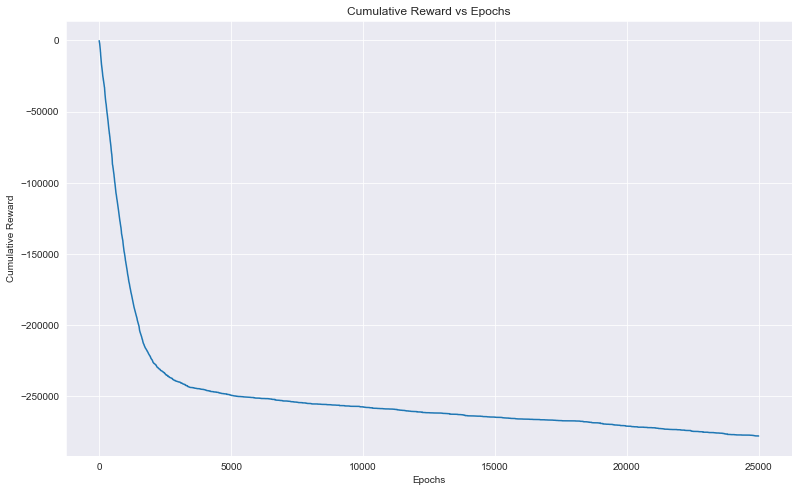

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.figure(figsize=(13,8))
sns.lineplot(range(EPOCHS),np.cumsum(rewards))
plt.xlabel('Epochs')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward vs Epochs')
# plt.savefig('cumulative_reward.jpg', dpi=400)
plt.show()

c:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


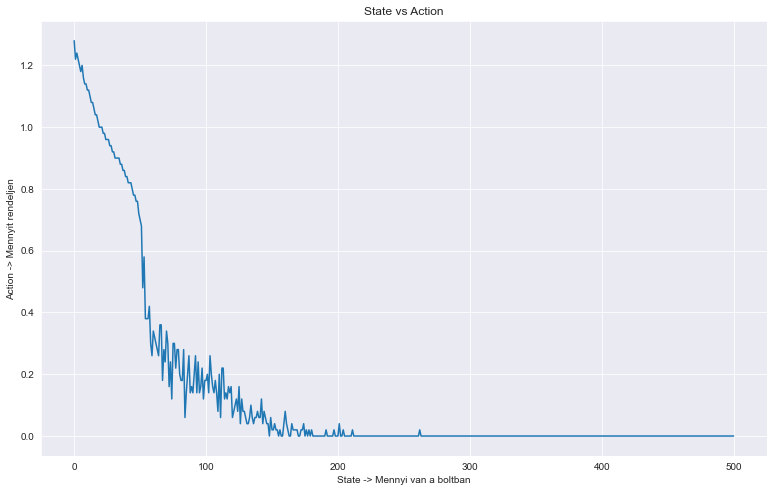

In [80]:
state = []
action = []
for i in range(501):
    state.append(i)
    action.append(VALUES[np.argmax(q_table[i])])
plt.figure(figsize=(13,8))
plt.title('State vs Action')
plt.ylabel("Action -> Mennyit rendeljen")
plt.xlabel("State -> Mennyi van a boltban")
sns.lineplot(state, action)
# plt.savefig('state_action.jpg', dpi=400)
plt.show()

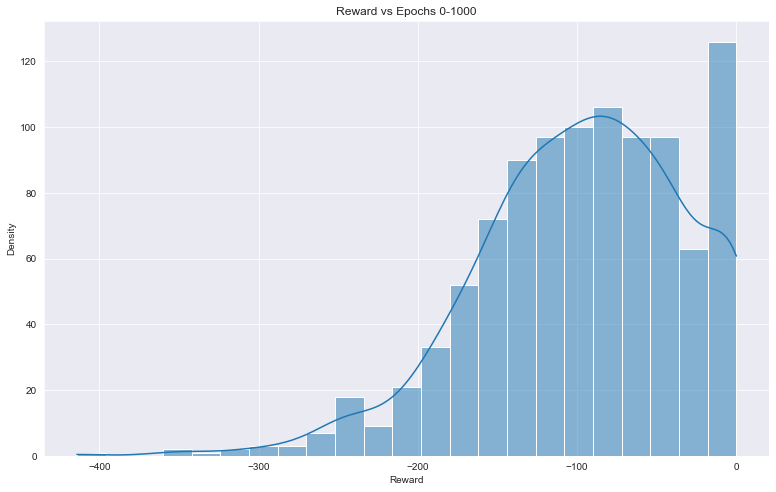

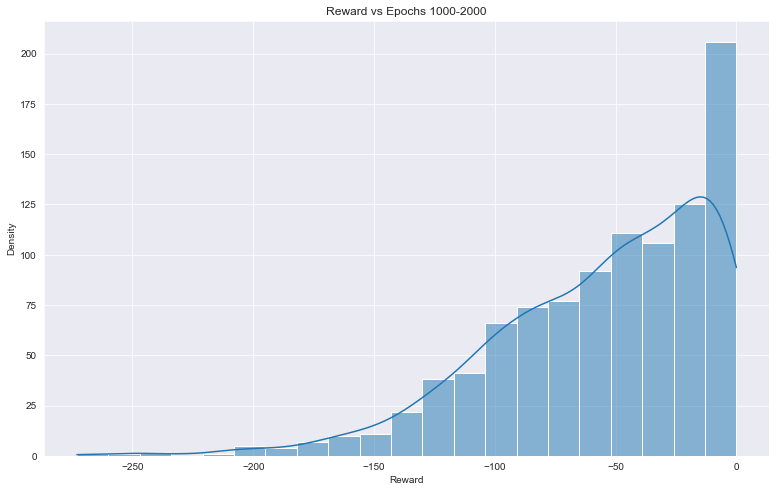

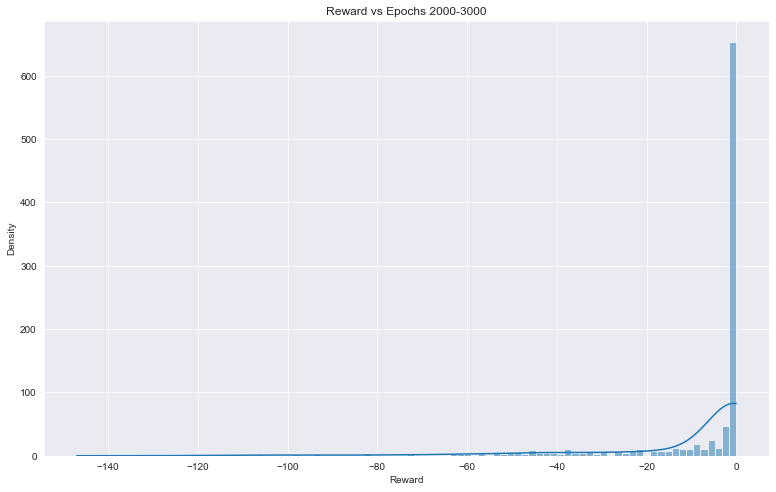

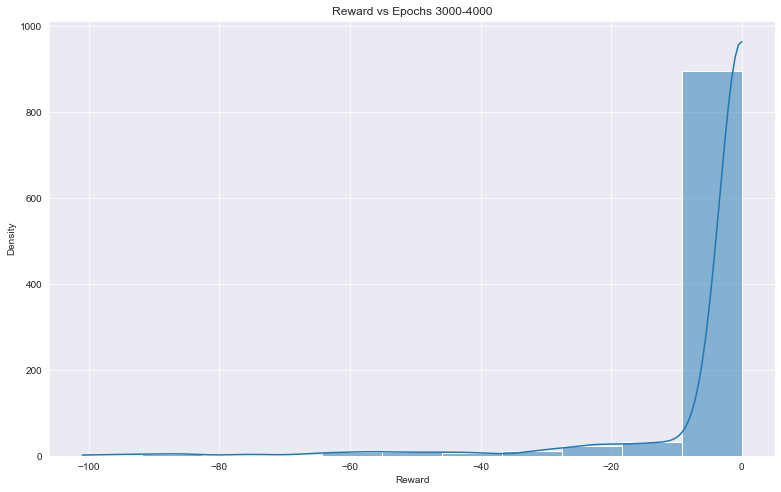

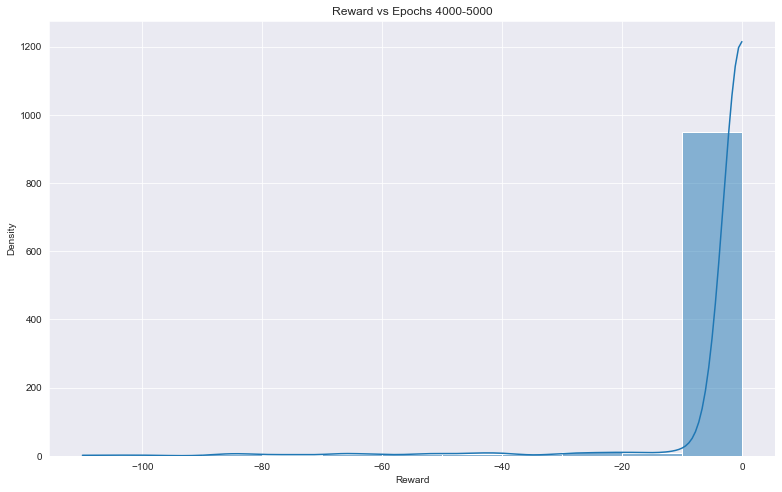

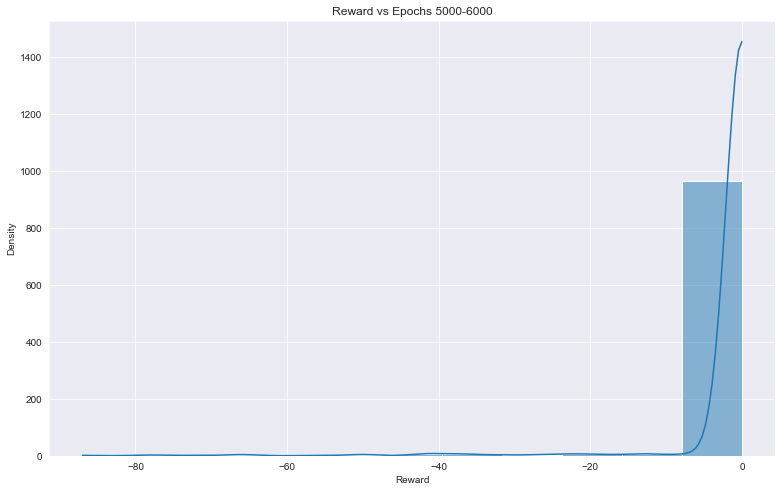

In [13]:
for i in range(1000,6001,1000):
    plt.figure(figsize=(13,8))
    sns.histplot(rewards[i-1000:i], kde=True)
    plt.xlabel('Reward')
    plt.ylabel('Density')
    plt.title(f'Reward vs Epochs {i-1000}-{i}')
    # plt.savefig(f'reward_EPOCH{i}.jpg', dpi=400)
    plt.show()

In [32]:
pd.DataFrame(q_table).head(10)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,-93.740593,-96.935749,-110.504839,-88.381164,-71.982871,-89.586755,-94.830902,-79.141633,-80.238322,-98.914616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-80.800000,-85.600000,-79.200000,-68.000000,-64.800000,-78.400000,-76.000000,-53.600000,-62.560000,-84.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-80.800000,-102.240000,-78.400000,-60.800000,-72.000000,-50.400000,-86.400000,-84.480000,-76.000000,-55.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-76.000000,-80.960000,-76.000000,-92.800000,-67.200000,-65.600000,-74.560000,-75.200000,-68.000000,-50.400000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-77.600000,-98.016000,-50.400000,-74.400000,-77.600000,-71.200000,-45.600000,-42.400000,-64.000000,-99.264000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-92.000000,-100.992000,-83.040000,-81.088000,-77.600000,-78.400000,-45.600000,-74.400000,-57.600000,-56.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-57.600000,-102.880000,-72.000000,-74.400000,-75.360000,-78.400000,-78.240000,-64.000000,-54.560000,-56.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-75.360000,-93.568000,-73.760000,-60.800000,-64.800000,-89.920000,-50.400000,-73.600000,-76.800000,-63.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-84.800000,-89.600000,-80.800000,-63.200000,-89.600000,-72.224000,-72.800000,-66.400000,-90.400000,-74.400000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-84.640000,-87.200000,-84.640000,-87.520000,-63.040000,-47.200000,-78.400000,-78.400000,-51.840000,-70.312960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
state = 100

np.argmax(q_table[state])

4